In [ ]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
!gdown 1i69ONNTpJ8vadzH0phnoT--6cGsSmWr2

Downloading...
From: https://drive.google.com/uc?id=1i69ONNTpJ8vadzH0phnoT--6cGsSmWr2
To: /content/dataset.csv
100% 21.2k/21.2k [00:00<00:00, 61.4MB/s]


In [ ]:
with open("./dataset.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

﻿Target,Comment

Each data point looks like this:

0,Tetap bang nabubuy bakal ngantongin SMG



In [ ]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [ ]:
pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords

def remove_stopwords(text):
	stop_words = stopwords.words('indonesian')

	imp_words = []

	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output

In [ ]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [ ]:
nltk.download('stopwords')
sentences, labels = parse_data_from_file("./dataset.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


There are 579 sentences in the dataset.

First sentence has 4 words (after removing stopwords).

There are 579 labels in the dataset.

The first 5 labels are ['0', '1', '0', '1', '1']


In [ ]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences) * training_split)

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 463 sentences for training.

There are 463 labels for training.

There are 116 sentences for validation.

There are 116 labels for validation.


In [ ]:
def fit_tokenizer(train_sentences, num_words, oov_token):

    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token )

    tokenizer.fit_on_texts(train_sentences)


    return tokenizer

In [ ]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 948 words

<OOV> token included in vocabulary


In [ ]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding = padding,maxlen = maxlen)
    return padded_sequences

In [ ]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (463, 120)

Padded validation sequences have shape: (116, 120)


In [ ]:
def tokenize_labels(all_labels, split_labels):
    sentences = []
    for t in split_labels:
        if t in all_labels:
            sentences.append(t)

    label_tokenizer = Tokenizer()

    label_tokenizer.fit_on_texts(all_labels)

    label_seq = np.array(label_tokenizer.texts_to_sequences(split_labels))
    validation_label_seq = np.array(label_tokenizer.texts_to_sequences(split_labels))

    label_seq_np =np.array([number - 1 for number in label_seq])


    return label_seq_np

In [ ]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [0]
 [1]
 [0]
 [0]]

First 5 labels of the validation set should look like this:
[[0]
 [1]
 [0]
 [1]
 [1]]

Tokenized labels of the training set have shape: (463, 1)

Tokenized labels of the validation set have shape: (116, 1)



In [ ]:
len(np.unique(labels, return_counts=True)[0])

2

In [ ]:
def create_model(num_words, embedding_dim, maxlen):

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(32, 1, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model


In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=50, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/50
15/15 [==============================] - 2s 24ms/step - loss: 0.6912 - accuracy: 0.5464 - val_loss: 0.6894 - val_accuracy: 0.5690
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6916 - accuracy: 0.5659 - val_loss: 0.6880 - val_accuracy: 0.5690
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.6878 - accuracy: 0.5659 - val_loss: 0.6871 - val_accuracy: 0.5690
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 0.6860 - accuracy: 0.5659 - val_loss: 0.6853 - val_accuracy: 0.5690
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.5659 - val_loss: 0.6841 - val_accuracy: 0.5690
Epoch 6/50
15/15 [==============================] - 0s 9ms/step - loss: 0.6880 - accuracy: 0.5659 - val_loss: 0.6837 - val_accuracy: 0.5690
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 0.6862 - accuracy: 0.5659 - val_loss: 0.6830 - val_accuracy: 0.5690
Epoch 8/50
15/15 

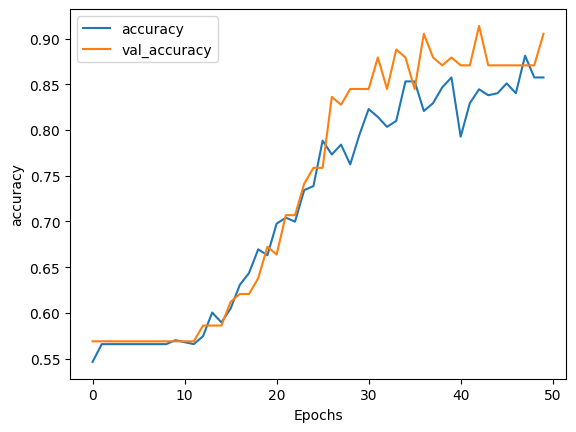

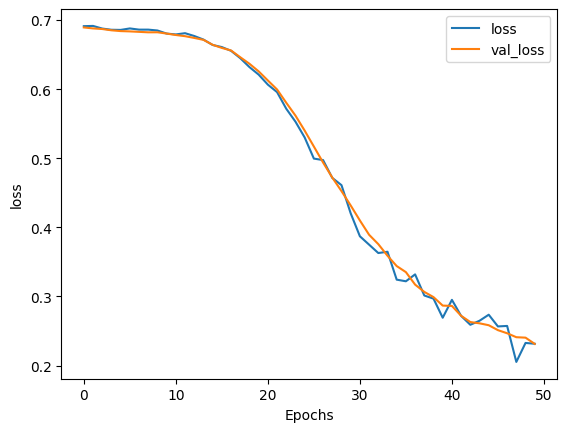

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
input_text = input("ketik yutubu komen disini")
input_seq = tokenizer.texts_to_sequences([input_text])
input_padded = pad_sequences(input_seq, padding=PADDING, maxlen=MAXLEN)
prediction = model.predict(input_padded)

print(prediction)

if prediction >= 0.5:
    print("bukan player ML")
else:
    print("cah ML pasti")


ketik yutubu komen disinigeek faam cacat
1/1 [==============================] - 0s 100ms/step
[[0.09415697]]
cah ML pasti
